In [79]:
import re
import nltk
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Getting the data

In [80]:
def get_data(path):

    df = pd.read_csv(path, sep = '\t', names = ['Sentence', 'Feeling'], encoding = 'utf-8')
    df = df.iloc[1:]
    
    return df

In [81]:
train_data = get_data(r"C:\Users\ivky1\University\Year_1\Semester_2\Text Mining\Project\TextMining\training_set.txt")
val_data = get_data(r"C:\Users\ivky1\University\Year_1\Semester_2\Text Mining\Project\TextMining\dev_set.txt")

## Preprocessing

In [82]:
nltk.download('wordnet')
nltk.download('stopwords') 
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ivky1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivky1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ivky1\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [83]:
def process(dataframe):
    
    processed_corpus = []
    stop_words = set(stopwords.words("english"))
    
    for i in tqdm(range(len(dataframe))):
        text = dataframe['Sentence'].iloc[i]
        
        # Remove punctuations
        text = re.sub('[^a-zA-Z]', ' ', text)

        # Convert to lowercase
        text = text.lower()        
        
        # Convert to list from string
        text = text.split()

        # Lemmatization
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in stop_words] 
        text = " ".join(text)
        processed_corpus.append(text)
        
    dataframe['Sentence'] = processed_corpus
        
    return dataframe

## Feature Extraction

In [84]:
def teacher_bog(train_df, val_df):
    vectorizer = CountVectorizer()
    vectorizer.fit(train_df['Sentence'])
    feature_space = vectorizer.transform(val_df['Sentence'])

    return feature_space.toarray()

In [85]:
def bag_of_words(train_df, val_df):
    
    vectorizer = CountVectorizer(max_features = 5000)
    vectorizer.fit(train_df['Sentence'])
    feature_space = vectorizer.transform(val_df['Sentence'])
    
    return feature_space.toarray()

In [86]:
bag_of_words(train_data, train_data).shape

(14000, 5000)

In [87]:
def n_grams(train_df, val_df):

    vectorizer = CountVectorizer(ngram_range = (2,2))
    vectorizer.fit(train_df['Sentence'])
    feature_space = vectorizer.transform(val_df['Sentence'])

    return feature_space.toarray()

In [88]:
def tf_idf(train_df, val_df):

    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_df['Sentence'])
    feature_space = vectorizer.transform(val_df['Sentence'])

    return feature_space

In [89]:
def tf_idf_n_grams(train_df, val_df):
    vectorizer = CountVectorizer(ngram_range = (2,2))
    transformer = TfidfTransformer()

    vectorizer.fit(train_df['Sentence'])
    transformer.fit(vectorizer)
    feature_space = transformer.transform(val_df['Sentence'])

    return feature_space

In [90]:
sgd = SGDClassifier(loss = 'log', random_state = 3)

In [91]:
# Best model: SGDClassifier + BoW

data = bag_of_words(train_data, train_data)
eval_data = bag_of_words(train_data, val_data)

method = "bag of words"
model_used = 'SGDCassifier'

fitted = sgd.fit(data, train_data['Feeling'])
y_train = fitted.predict(data)
y_predict = fitted.predict(eval_data)

print(f"Training Accuracy of {model_used} using {method} %.3f" 
%accuracy_score(train_data['Feeling'], y_train))

print(f"Training F1 of {model_used} using {method} %.3f" 
%f1_score(train_data['Feeling'], y_train, average = 'weighted'))

print(f"Val Accuracy of {model_used} using {method} %.3f" 
%accuracy_score(val_data['Feeling'], y_predict))

print(f"Val F1 of {model_used} using {method} %.3f" 
%f1_score(val_data['Feeling'], y_predict, average = 'weighted'))

Training Accuracy of SGDCassifier using bag of words 0.596
Training F1 of SGDCassifier using bag of words 0.594
Val Accuracy of SGDCassifier using bag of words 0.380
Val F1 of SGDCassifier using bag of words 0.372


In [92]:
processed_val = val_data.copy()
process(processed_val)

C:\Users\ivky1\AppData\Local\Temp\ipykernel_63328\2719440103.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(dataframe))):


  0%|          | 0/1000 [00:00<?, ?it/s]

,Sentence,Feeling
1,happens gold safe,4
2,natural get cold foot,8
3,lucky,7
4,little anxious get whoop et as,2
5,think know affair government official,1
...,...,...
996,ask careful,4
997,like jazz pal,7
998,put,1
999,ever imagine person spot like,7


In [93]:
strong_baseline = SVC(kernel = 'linear').fit(teacher_bog(train_data, train_data), train_data['Feeling'])
teacher_pred = strong_baseline.predict(teacher_bog(train_data, processed_val))

In [94]:
our_model = [accuracy_score(val_data['Feeling'], y_predict), f1_score(val_data['Feeling'], y_predict, average = 'weighted'), recall_score(val_data['Feeling'], y_predict, average = 'weighted'), precision_score(val_data['Feeling'], y_predict, average = 'weighted')]
teacher_model = [accuracy_score(val_data['Feeling'], teacher_pred), f1_score(val_data['Feeling'], teacher_pred, average = 'weighted'), recall_score(val_data['Feeling'], teacher_pred, average = 'weighted'), precision_score(val_data['Feeling'], teacher_pred, average = 'weighted')]

In [95]:
pd.DataFrame([our_model, teacher_model], columns = ['acc', 'f1', 'recall', 'precision'], index = ['Our Model', 'Strong Baseline'])

,acc,f1,recall,precision
Our Model,0.380,0.372251,0.380,0.377286
Strong Baseline,0.346,0.330264,0.346,0.346213


In [96]:
print(classification_report(val_data['Feeling'], y_predict, target_names=np.unique(val_data['Feeling']), digits=4))

              precision    recall  f1-score   support

           1     0.4000    0.5403    0.4597       211
           2     0.3713    0.4412    0.4032       170
           3     0.2979    0.1818    0.2258        77
           4     0.4000    0.3077    0.3478       104
           5     0.4021    0.4021    0.4021        97
           6     0.4167    0.2874    0.3401        87
           7     0.3582    0.2500    0.2945        96
           8     0.3519    0.3608    0.3563       158

    accuracy                         0.3800      1000
   macro avg     0.3747    0.3464    0.3537      1000
weighted avg     0.3773    0.3800    0.3723      1000



In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix

y_test = val_data['Feeling']

cf_matrix = confusion_matrix(y_test, y_predict)


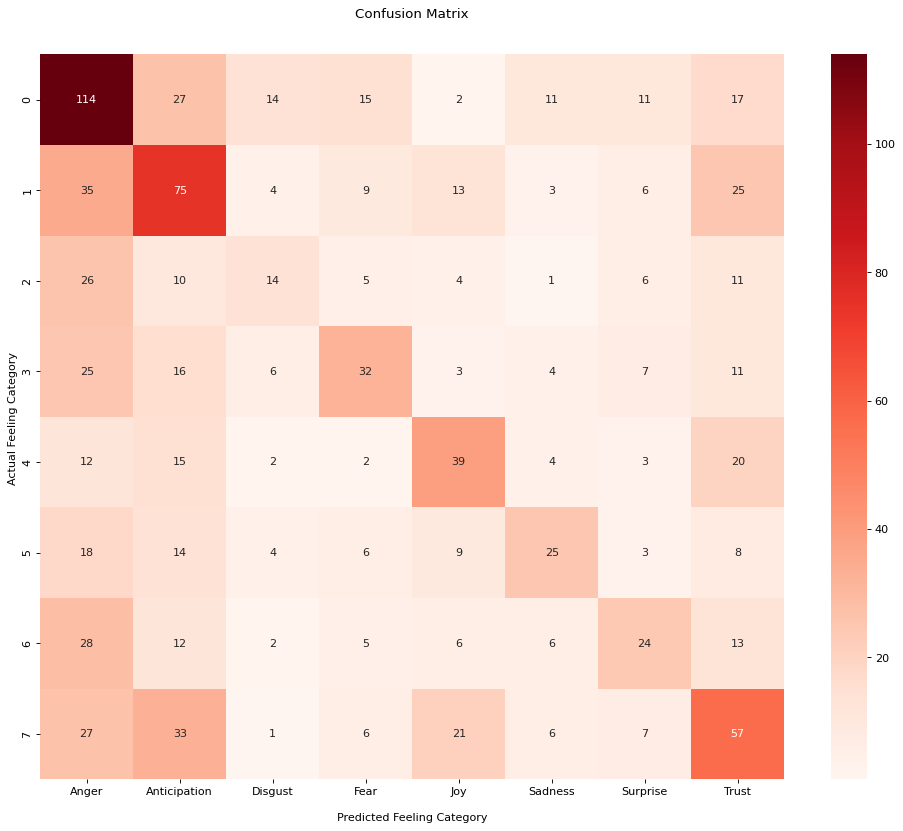

In [98]:
figure(figsize=(15, 12), dpi=80)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds', fmt='g')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Feeling Category')
ax.set_ylabel('Actual Feeling Category ')
ax.xaxis.set_ticklabels(['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust'])
ax.xaxis.set_ticklabels(['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust'])
plt.show()

# Tests on solution set

In [99]:
test_set = get_data(r"C:\Users\ivky1\University\Year_1\Semester_2\Text Mining\Project\TextMining\test_set.txt")

In [100]:
test_set

,Sentence,Feeling
1,"Come , let's go get that automobile .",NaN
2,"Well , some other time , then ?",NaN
3,He's in trouble . Boy ?,NaN
4,Criminal gang unit to take control .,NaN
5,By Molto . No discussion . Interview .,NaN
...,...,...
1996,Let's do some good .,NaN
1997,"Hey , you're looking good .",NaN
1998,"Have they moved the embassy , or are you hijac...",NaN
1999,What that !,NaN


In [101]:
test_set['Feeling'] = fitted.predict(bag_of_words(train_data, test_set))

In [102]:
test_set

,Sentence,Feeling
1,"Come , let's go get that automobile .",2
2,"Well , some other time , then ?",2
3,He's in trouble . Boy ?,4
4,Criminal gang unit to take control .,8
5,By Molto . No discussion . Interview .,1
...,...,...
1996,Let's do some good .,2
1997,"Hey , you're looking good .",5
1998,"Have they moved the embassy , or are you hijac...",1
1999,What that !,7
